In [2]:
from Bio import SeqIO, Seq, SeqRecord
import gzip, pickle, os
import re

import yaml

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import timeit

os.chdir("C:/Users/Ted/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/")
import nextgenhelp as ngh

import logging

logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

%matplotlib inline

In [3]:
reload(ngh)

<module 'nextgenhelp' from 'C:\Users\Ted\Google Drive\To File - Research Docs\Screening\nextgenAnalysis\nextgen4B\nextgenhelp.pyc'>

#YAML importing

In [205]:
folder = "C:/Users/Ted/Google Drive/To File - Research Docs/Screening/nextgenAnalysis/Data/2015_09_03_AMD/"
os.chdir(folder)

expt_data_f = open('samples.yaml')
samps = yaml.load(expt_data_f) # Should probably make this a class at some point...
expt_data_f.close()

In [206]:
runs = samps['ngsruns']

In [209]:
for run in runs.keys():
    expts = runs[run]['experiments']
    
    bcs = []
    for expt in expts:
        bcs.append(samps['experiments'][expt]['barcode'])
    print bcs

['TTTTT']
['TTTAA']
['TTTGG']
['TTTCC']
['TTGTG']
['TTTTT', 'TTTGG', 'TTTAA', 'TTGTG', 'TTTCC']


In [166]:
run = 'run1'
exps = samps['ngsruns'][run]['experiments']

In [167]:
fname = samps['ngsruns'][run]['f_read_name']
fname2 = samps['ngsruns'][run]['pe_read_name']

iterator = SeqIO.parse(gzip.open(fname), 'fastq')
iterator_pe = SeqIO.parse(gzip.open(fname2), 'fastq')

In [168]:
bc1_seq = 'TTTTT'
bc2_seq = 'TTTGG'
bc3_seq = 'TTTAA'
bc4_seq = 'TTGTG'
bc5_seq = 'TTTCC'

# bc_seqs = [bc1_seq, bc2_seq, bc3_seq, bc4_seq, bc5_seq]
bc_seqs = [bc1_seq]

#Filtering Playground

In [169]:
# Compile REs for CS1, CS2
f_re = re.compile(samps['ngsruns'][run]['filter_seqs']['forward'][0])
r_re = re.compile(samps['ngsruns'][run]['filter_seqs']['reverse'][0])

In [170]:
# Filter forward sequences for CS2
f_seqs = ngh.filterSeqs(ngh.loadNGSFileToIterator(fname), f_re)

INFO:root:Started regex filter: AGACCAAGTCTCTGCTACCGTA
INFO:root:Finished regex filter. Kept 90837 sequences.


In [171]:
# Filter paired-end sequences for CS1
pe_seqs = ngh.filterSeqs(ngh.loadNGSFileToIterator(fname2), r_re)

INFO:root:Started regex filter: TGTAGAACCATGTCGTCAGTGT
INFO:root:Finished regex filter. Kept 81138 sequences.


In [172]:
bc_filtered = ngh.barcodeDemux(f_seqs, bc_seqs)

INFO:root:Started barcode demuxing.
INFO:root:Finished barcode demuxing. Kept 87449 of 90837 sequences.


In [173]:
bc = bc1_seq
bcSeqs = bc_filtered

seqs = ngh.stripForwardBarcodes(bcSeqs[bc])

In [174]:
seqs = ngh.filterPEMismatches(seqs, pe_seqs, ngh.copiedFunctionGenerator(f_re), 
            barcode_l=0)

INFO:root:Started Paired-End Filtering
INFO:root:Processed 5000 out of 87449
INFO:root:Processed 10000 out of 87449
INFO:root:Processed 15000 out of 87449
INFO:root:Processed 20000 out of 87449
INFO:root:Processed 25000 out of 87449
INFO:root:Processed 30000 out of 87449
INFO:root:Processed 35000 out of 87449
INFO:root:Processed 40000 out of 87449
INFO:root:Processed 45000 out of 87449
INFO:root:Processed 50000 out of 87449
INFO:root:Processed 55000 out of 87449
INFO:root:Processed 60000 out of 87449
INFO:root:Processed 65000 out of 87449
INFO:root:Processed 70000 out of 87449
INFO:root:Processed 75000 out of 87449
INFO:root:Processed 80000 out of 87449
INFO:root:Processed 85000 out of 87449
INFO:root:Finished Paired-End Filtering
INFO:root:Kept 75792 of 87449 forward sequences after coordinate filtering
INFO:root:Kept 75791 of 75792 forward sequences after paired-end sequence matching


In [177]:
seqs = ngh.seqLenFilter(seqs)

INFO:root:Started Length Filtering
INFO:root:Finished Length Filtering. Kept 22764 of 75791 sequences.


In [186]:
seqs = ngh.qualityFilter(seqs)

INFO:root:Started Quality Score Filtering
INFO:root:Finished Quality Score Filtering. Kept 18084 of 22764 sequences.


In [187]:
aTemplateStr = """ACACTGACGACATGGTTCTACATTTTTGATGGTCATAGCTGTTGTATTTTTATTTTCATTCATTCATTCATTGCATCCATCGACTGAGCTACTGACGTACTGACTGACTTAGTTATGATTTTAGACCAAGTCTCTGCTACCGTA"""
aTemplate = SeqRecord.SeqRecord(Seq.Seq(aTemplateStr),
                                id='Template_for_%s' % (bc))

In [188]:
seqs[0]

SeqRecord(seq=Seq('GATGGTCATAGCTGTTGTATTTTTATTTTCATTCATTCATTCATTGCATCCATC...TTT', SingleLetterAlphabet()), id='M03050:15:000000000-AHT3B:1:1101:14620:1227', name='M03050:15:000000000-AHT3B:1:1101:14620:1227', description='M03050:15:000000000-AHT3B:1:1101:14620:1227 1:N:0:57', dbxrefs=[])

In [196]:
reload(ngh.alignfilter)
seqs_aln = ngh.alignfilter.alignmentFilter(seqs, aTemplate)

INFO:root:Started alignment-based filtering
INFO:root:Began EMBOSS needle routine
INFO:root:Finished EMBOSS needle routine
INFO:root:Cleaning up temp files
INFO:root:Finished alignment-based filtering. Kept 16915 of 18084 sequences.


In [200]:
seqs_aln[0]

SeqRecord(seq=Seq('---------------------------GATGGTCATAGCTGTTGTATTTTTATT...---', SingleLetterAlphabet()), id='M03050:15:000000000-AHT3B:1:1101:14620:1227', name='<unknown name>', description='M03050:15:000000000-AHT3B:1:1101:14620:1227', dbxrefs=[])

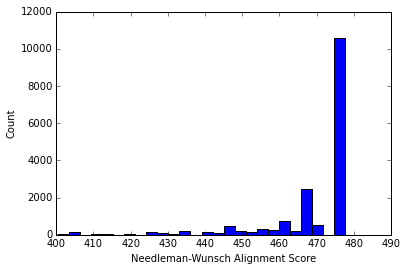

In [202]:
plt.figure()
plt.hist([s.annotations['alnscore'] for s in seqs_aln], 30)
plt.xlabel('Needleman-Wunsch Alignment Score')
plt.ylabel('Count')
plt.show()

# Some Cursory Analysis
So, a few things maybe left to take care of on the filtering side of things

* Not filtering out all of the CS2 adapters. Specifically it looks like some SNPs are getting through
    * These are filtered out by alignment scores for the first dataset, but needs to be general
* Q scores... +/-? How do they effect the analysis?

In [247]:
def getPositionalMisinc(seqs, template, n, letterorder=['C', 'A', 'T', 'G']):
    mat = np.zeros([len(letterorder), len(letterorder), len(seqs)])
    
    for i in range(len(seqs)):
        if seqs[i][n] in letterorder and template[n] in letterorder:
            # Indexing is [template_bp][sequencing_bp]
            mat[letterorder.index(template[n])][letterorder.index(seqs[i][n])][i] += 1
            
    return mat

def getAllPositionMisincs(seqs, template, letterorder=['C', 'A', 'T', 'G']):
    mat = np.zeros([len(letterorder), len(letterorder), len(template)])
    
    for i in range(len(template)):
        posMat = getPositionalMisinc(seqs, template, i, letterorder=letterorder)
        mat[:,:,i] = np.sum(posMat, axis=2)
    
    return mat

def simpleMisincStats(m, letterorder=['C', 'A', 'T', 'G'], verbose=False):
    # Collapse matrix along the z-axis... Maybe don't need to make this default behavior?
    # Could also just make it if 'm' has a 3rd dimension...
    s_m = np.sum(m, axis=2, dtype='float')
    f_m = s_m / np.sum(np.sum(s_m)) # Counts for each divided by total counts
    
    if verbose:
        for i in range(len(letterorder)):
            for j in range(len(letterorder)):
                print "%c -> %c: %f%%" % (letterorder[i], letterorder[j], f_m[i][j]*100)
                
    return f_m

In [267]:
import pandas as pd

def posMtoPandas(m, letterorder=['C', 'A', 'T', 'G']):
    labels = []
    for i in range(len(letterorder)):
        for j in range(len(letterorder)):
            labels.append(letterorder[i]+'->'+letterorder[j])
    
    df = pd.DataFrame(data=np.zeros([m.shape[2], len(labels)]), columns=labels)
    for i in range(len(letterorder)):
        for j in range(len(letterorder)):
            df[letterorder[i]+'->'+letterorder[j]] = m[i,j,:]
    
    return df

In [268]:
foo = posMtoPandas(bigMat)

In [271]:
print foo

     C->C  C->A  C->T  C->G  A->C   A->A  A->T  A->G  T->C  T->A   T->T  T->G  \
0       0     0     0     0     0      0     0     0     0     0      0     0   
1       0     0     0     0     0      0     0     0     0     0      0     0   
2       0     0     0     0     0      0     0     0     0     0      0     0   
3       0     0     0     0     0      0     0     0     0     0      0     0   
4       0     0     0     0     0      0     0     0     0     0      0     0   
5       0     0     0     0     0      0     0     0     0     0      0     0   
6       0     0     0     0     0      0     0     0     0     0      0     0   
7       0     0     0     0     0      0     0     0     0     0      0     0   
8       0     0     0     0     0      0     0     0     0     0      0     0   
9       0     0     0     0     0      0     0     0     0     0      0     0   
10      0     0     0     0     0      0     0     0     0     0      0     0   
11      0     0     0     0 

In [270]:
foo.iloc[50]

C->C        0
C->A        0
C->T        0
C->G        0
A->C        0
A->A        0
A->T        0
A->G        0
T->C        7
T->A        0
T->T    16906
T->G        0
G->C        0
G->A        0
G->T        0
G->G        0
Name: 50, dtype: float64

In [228]:
getPositionalMisinc(seqs_aln, aTemplate, 50).shape

(4L, 4L, 16915L)

In [225]:
bigMat = getAllPositionMisincs(seqs_aln, aTemplate)

In [250]:
labels = []
letterorder = ['C', 'A', 'T', 'G']

for i in range(len(letterorder)):
        for j in range(len(letterorder)):
            labels.append(letterorder[i]+'->'+letterorder[j])

In [252]:
[foo.reshape(foo.size, order='F'), labels]

[array([  0.00000000e+00,   0.00000000e+00,   7.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.69060000e+04,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00]),
 ['C->C',
  'C->A',
  'C->T',
  'C->G',
  'A->C',
  'A->A',
  'A->T',
  'A->G',
  'T->C',
  'T->A',
  'T->T',
  'T->G',
  'G->C',
  'G->A',
  'G->T',
  'G->G']]

In [254]:
aTemplate[50]

'T'

In [240]:
foo = bigMat[:,:,50]
print foo

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  7.00000000e+00   0.00000000e+00   1.69060000e+04   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]]


In [246]:
foo.reshape(foo.size, order='F')

array([  0.00000000e+00,   0.00000000e+00,   7.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   1.69060000e+04,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00])

In [226]:
f_m = simpleMisincStats(bigMat, verbose=True)

C -> C: 18.027542%
C -> A: 0.006844%
C -> T: 0.012182%
C -> G: 0.001695%
A -> C: 0.015196%
A -> A: 22.118363%
A -> T: 0.005903%
A -> G: 0.029764%
T -> C: 0.062039%
T -> A: 0.011554%
T -> T: 42.721537%
T -> G: 0.081819%
G -> C: 0.001381%
G -> A: 0.010298%
G -> T: 0.002323%
G -> G: 16.891559%


In [227]:
(1-f_m.trace())*100

0.24099850490504338

In [231]:
sum(sum(f_m))

1.0

In [274]:
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

tempSeq = SeqRecord(Seq(aTemplateStr), id='template', name='template')

In [275]:
tempSeq

SeqRecord(seq=Seq('ACACTGACGACATGGTTCTACATTTTTGATGGTCATAGCTGTTGTATTTTTATT...GTA', Alphabet()), id='template', name='template', description='<unknown description>', dbxrefs=[])